<!---
Latex Macros
-->
$$
\newcommand{\Xs}{\mathcal{X}}
\newcommand{\Ys}{\mathcal{Y}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\repr}{\mathbf{f}}
\newcommand{\repry}{\mathbf{g}}
\newcommand{\x}{\mathbf{x}}
\newcommand{\vocab}{V}
\newcommand{\params}{\boldsymbol{\theta}}
\newcommand{\param}{\theta}
\DeclareMathOperator{\perplexity}{PP}
\DeclareMathOperator{\argmax}{argmax}
\DeclareMathOperator{\argmin}{argmin}
\newcommand{\train}{\mathcal{D}}
\newcommand{\counts}[2]{\#_{#1}(#2) }
\newcommand{\indi}{\mathbb{I}}
$$

In [154]:
%%capture
%load_ext autoreload
%autoreload 2
%matplotlib inline
# preamble
import sys
sys.path.append("..")
import statnlpbook.transition as transition

# Transition-based dependency parsing

This chapter is influenced by the [EACL 2014 tutorial](http://stp.lingfil.uu.se/~nivre/eacl14.html) by Ryan McDonald and Joakim Nivre.

In the [parsing chapter](parsing.ipynb) we saw how to develop a syntactic parser based on context-free grammars (CFG). In this chapter we will see how to develop a syntactic parser based on a different paradigm, dependency parsing.

The key idea in dependency parsing is that syntactic structure of lexical items, linked by binary
asymmetric relations called dependencies. [Nivre, 2008](http://www.mitpressjournals.org/doi/pdf/10.1162/coli.07-056-R1-07-027) More simply, syntax is represented as directed edges between words. Thus unlike the trees in [CFG parsing](parsing.ipynb), dependency trees have only terminal nodes (the words of the sentences), which can appear as leaves as and non-leaf nodes. Here is the dependency graph for the sentence:

> "Economic news had little effect on financial markets"

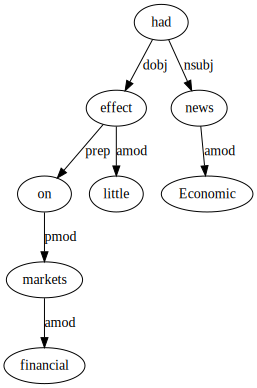

In [155]:
tokens = ["Economic", "news", "had", "little", "effect", "on", "financial", "markets", "."]
edges = set([(1,0,"amod"),(2,1,"nsubj"), (2, 4, "dobj"), (4,3,"amod"), (4,5, "prep"), (5,7,"pmod"), (7,6,"amod")])

transition.render_tree(tokens, edges)

TODO: Formal description by Nivre, constraints:

- connected
- acyclic
- single-head

Note that the dependency parse tree shown above is not connected since the period is left without an edge. To ensure that dependency trees are well-formed, we introduce a ROOT node which points to the main verb of the sentence, as well as any punctuation.

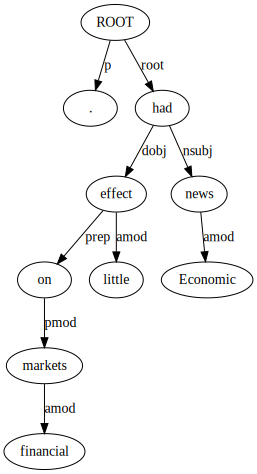

In [156]:
tokens = ["ROOT", "Economic", "news", "had", "little", "effect", "on", "financial", "markets", "."]
edges = set([(0,3, "root"), (0,9,"p"), (2,1,"amod"),(3,2,"nsubj"), (3, 5, "dobj"), (5,4,"amod"), (5,6, "prep"), (6,8,"pmod"), (8,7,"amod")])

transition.render_tree(tokens, edges)

A straightforward approach to dependency parsing would be given a sentence \\(\x\\), to enumerate over all valid graphs for the sentence $\y\in\Ys_x$ and score them using an appropriate function \\(s_\params(\x,\y)\\), a case of a [structured prediction](structured_prediction.ipynb) problem. While such an approach is possible and there has been a lot of work often referred to as graph-based parsing, e.g. [McDonald et al. (2006)](http://www.ryanmcd.com/papers/MS-CIS-05-11.pdf), in this note we will focus on transition-based approaches, which decompose the task into a sequence of decisions that can be learned with a classifier.

To perform transition-based parsing we first need to define our transition system consisting of the following elements:

- Input:

- Configuration:
    - Arcs: the dependency edges predicted so far (we switch from edges to arcs to comply with the dependency parsing literature)
    - Buffer
    - Stack

- Actions:
    - shift
    - reduce
    - rightArc-label
    - leftArc-label

We further define two special configurations:
- initial
- terminal

In [182]:
from collections import deque

class Configuration():
    def __init__(self, tokenized_sentence):
        # This implements the initial configuration for a sentence
        self.arcs = set()
        self.buffer = deque()
        for idx, token in enumerate(tokenized_sentence):
            self.buffer.append(token+ "_" + str(idx))
        self.stack = []
        
import copy
def parse(tokenized_sentence, actions):
    # This stores the (configuration, action) tuples generated
    transitions = []
    
    # Initialize the configuration
    configuration = Configuration(tokenized_sentence)
    transitions.append((copy.deepcopy(configuration), "INIT"))
    
    for action in actions:
        if action == "shift":
            token = configuration.buffer.popleft()
            configuration.stack.append(token)
        elif action == "reduce":
            configuration.stack.pop()
        elif action.startswith("leftArc"):
            # Get the dependent token
            dependentToken, dependentTokenId = configuration.stack.pop().split("_")

            # check if it is headed already:
            headed = False
            for arc in configuration.arcs:
                if arc[1] == int(dependentTokenId):
                    headed = True
            if headed:
                raise Exception("Dependent token has an incoming edge already")
            
            label = action.split("-")[1]
            headToken, headTokenId = configuration.buffer[0].split("_")
            
            configuration.arcs.add((int(headTokenId),int(dependentTokenId),label))

        elif action.startswith("rightArc"):
            label = action.split("-")[1]            
            
            dependent = configuration.buffer.popleft()
            dependentToken, dependentTokenId = dependent.split("_")
            headToken, headTokenId = configuration.stack[-1].split("_")
            
            configuration.arcs.add((int(headTokenId),int(dependentTokenId),label))
            
            configuration.stack.append(dependent)
            
        
        transitions.append((copy.deepcopy(configuration), action))
    
    if len(configuration.buffer) == 0:
        transitions.append((copy.deepcopy(configuration), "TERMINAL"))
    return transitions

TODO: Let's see how we can parse the example sentence using this transition system

In [183]:
tokenized_sentence = ["ROOT", "Economic", "news", "had", "little", "effect", "on", "financial", "markets", "."]
actions = ["shift","shift", "leftArc-amod", "shift", "leftArc-nsubj", "rightArc-root", "shift", "leftArc-amod", "rightArc-dobj", "rightArc-prep", "shift", "leftArc-amod", "rightArc-pmod", "reduce", "reduce", "reduce", "reduce", "rightArc-p"]

transitions = parse(tokenized_sentence, actions)

transition.render_transitions(transitions, tokenized_sentence)

buffer,stack,parse,action
ROOT_0 Economic_1 news_2 had_3 little_4 effect_5 on_6 financial_7 markets_8 ._9,,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3",INIT
Economic_1 news_2 had_3 little_4 effect_5 on_6 financial_7 markets_8 ._9,ROOT_0,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3",shift
news_2 had_3 little_4 effect_5 on_6 financial_7 markets_8 ._9,ROOT_0 Economic_1,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3",shift
news_2 had_3 little_4 effect_5 on_6 financial_7 markets_8 ._9,ROOT_0,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 2 --> 2 news <!-- 1 --> 1 Economic <!-- 2->1 --> 2->1 amod",leftArc-amod
had_3 little_4 effect_5 on_6 financial_7 markets_8 ._9,ROOT_0 news_2,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 2 --> 2 news <!-- 1 --> 1 Economic <!-- 2->1 --> 2->1 amod",shift
had_3 little_4 effect_5 on_6 financial_7 markets_8 ._9,ROOT_0,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 2 --> 2 news <!-- 1 --> 1 Economic <!-- 2->1 --> 2->1 amod <!-- 3 --> 3 had <!-- 3->2 --> 3->2 nsubj",leftArc-nsubj
little_4 effect_5 on_6 financial_7 markets_8 ._9,ROOT_0 had_3,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 ROOT <!-- 3 --> 3 had <!-- 0->3 --> 0->3 root <!-- 2 --> 2 news <!-- 3->2 --> 3->2 nsubj <!-- 1 --> 1 Economic <!-- 2->1 --> 2->1 amod",rightArc-root
effect_5 on_6 financial_7 markets_8 ._9,ROOT_0 had_3 little_4,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 ROOT <!-- 3 --> 3 had <!-- 0->3 --> 0->3 root <!-- 2 --> 2 news <!-- 3->2 --> 3->2 nsubj <!-- 1 --> 1 Economic <!-- 2->1 --> 2->1 amod",shift
effect_5 on_6 financial_7 markets_8 ._9,ROOT_0 had_3,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 5 --> 5 effect <!-- 4 --> 4 little <!-- 5->4 --> 5->4 amod <!-- 0 --> 0 ROOT <!-- 3 --> 3 had <!-- 0->3 --> 0->3 root <!-- 2 --> 2 news <!-- 3->2 --> 3->2 nsubj <!-- 1 --> 1 Economic <!-- 2->1 --> 2->1 amod",leftArc-amod
on_6 financial_7 markets_8 ._9,ROOT_0 had_3 effect_5,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1

TODO: How do we learn a parser? Our training data? features? Use any classifier we like, for example [loglinear classification models](doc_classify.ipynb).
Key point is that we converted a structure prediction problem into a sequence of classification actions that are guaranteed to give us a valid dependency parse:

TODO: Different transition systems: they consist of some elementary actions. The key thing is the learnability of the system: ambiguity is confusing.

TODO: Dynamic oracles to help with the ambiguity that we are left with (example from Nivre), it was an implementation of the idea of expert policy from imitation learning (Searn/DAgger)

TODO: Non-projectivity with dual stacks and better visualisations